# Sheet Music Reader Convolution Neural Network

## Import Necessary Libraries

In [1]:
# 💡 Stable Import Setup

import os
import sys

#  Fix OpenMP / libiomp5md.dll conflict (Torch + OpenCV) 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# --- Detect environment: Jupyter vs script ---
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        return shell == "ZMQInteractiveShell"  # Jupyter or VSCode interactive
    except NameError:
        return False  # Standard Python script

# --- Configure matplotlib backend accordingly ---
import matplotlib
if is_notebook():
    # Inline plotting for Jupyter
    matplotlib.use('module://matplotlib_inline.backend_inline')
else:
    # Non-interactive backend for scripts
    matplotlib.use("Agg")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
import seaborn as sns
import mido
from mido import Message, MidiFile, MidiTrack

print("✅ Environment initialized safely.")
print("Matplotlib backend:", matplotlib.get_backend())
print("Torch version:", torch.__version__)
print("OpenCV version:", cv2.__version__)


✅ Environment initialized safely.
Matplotlib backend: module://matplotlib_inline.backend_inline
Torch version: 2.8.0+cpu
OpenCV version: 4.10.0


## Make Image Prep Function

In [2]:
def clean_sheet_music(image_path):
    import cv2
    import numpy as np

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read {image_path}")

    blurred = cv2.GaussianBlur(img, (3, 3), 0)

    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    kernel = np.ones((1, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    result = cv2.bitwise_not(cleaned)
    return result


def plot_confusion_matrix_seaborn(cm, classes, title='Confusion Matrix', figsize=(10, 8), cmap='Blues'):
    """
    Plot a confusion matrix using Seaborn heatmap with professional formatting.

    Args:
        cm (np.array): Confusion matrix (square array)
        classes (list): List of class names
        title (str): Plot title
        figsize (tuple): Figure size
        cmap (str): Seaborn/Matplotlib colormap
    """
    plt.figure(figsize=figsize)
    sns.set(style='white')  # clean white background
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                     xticklabels=classes, yticklabels=classes,
                     cbar=True, square=True, linewidths=0.8, linecolor='gray')

    # Improve aesthetics
    plt.title(title, fontsize=16, pad=25)
    plt.xlabel('Predicted Label', fontsize=20, labelpad=10)
    plt.ylabel('True Label', fontsize=20, labelpad=10)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.tight_layout()
    plt.show()


def plot_image_matrix(images, labels, n_rows=4, n_cols=4, figsize=(8,8)):
    """
    Plot a grid of input images.
    
    Args:
        images (list or np.array): Grayscale images, shape (N, H, W) or (N, 1, H, W)
        labels (list of str): Corresponding labels to display under images
        n_rows, n_cols: Grid size
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    for i in range(min(len(images), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, i+1)
        img = images[i]
        if img.ndim == 3 and img.shape[0] == 1:
            img = img[0]  # remove channel
        plt.imshow(img, cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


## Make CNN Model

In [3]:
class NoteCNN(nn.Module):
    def __init__(self, num_pitches, num_durations):
        super().__init__()
        """
        A Convolutional Neural Network for predicting musical note pitches and durations.
        Args:
            num_pitches (int): Number of unique pitch classes.
            num_durations (int): Number of unique duration classes.
        Input:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, height, width)
        Output:
            pitch_out (torch.Tensor): Output tensor for pitch classification of shape (batch_size, num_pitches)
            dur_out (torch.Tensor): Output tensor for duration classification of shape (batch_size, num_durations)
        """
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # works for input 32x32
        self.pitch_head = nn.Linear(128, num_pitches)
        self.duration_head = nn.Linear(128, num_durations)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        pitch_out = self.pitch_head(x)
        dur_out = self.duration_head(x)
        return pitch_out, dur_out

## Make Class for Loading and Processing Dataset

In [4]:
class NoteDataset(Dataset):
    def __init__(self, csv_path, image_dir, clean_images=True):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.clean_images = clean_images

        # Keep only rows where the image exists
        self.df = self.df[self.df['name'].apply(lambda x: os.path.exists(os.path.join(self.image_dir, x + ".png")))].reset_index(drop=True)

        # Map pitches and durations to indices
        self.unique_pitches = sorted(self.df['pitch'].unique())
        self.unique_durations = sorted(self.df['duration'].unique())
        self.pitch_to_idx = {p: i for i, p in enumerate(self.unique_pitches)}
        self.dur_to_idx = {d: i for i, d in enumerate(self.unique_durations)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["name"] + ".png")

        # Load and optionally clean the image
        img = clean_sheet_music(img_path) if self.clean_images else cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).unsqueeze(0)

        pitch = self.pitch_to_idx[row["pitch"]]
        duration = self.dur_to_idx[row["duration"]]

        return img, pitch, duration

## Train and Test

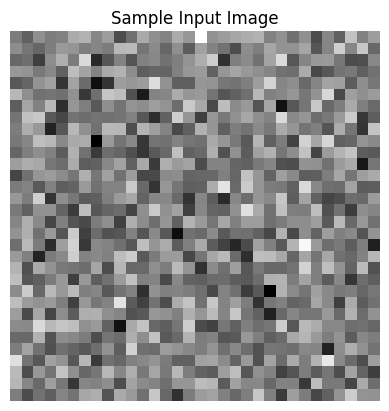

Pitch output shape: torch.Size([1, 86])
Duration output shape: torch.Size([1, 9])
Epoch [1/150] | Loss: 6.5890
Epoch [2/150] | Loss: 5.8312
Epoch [3/150] | Loss: 4.9212
Epoch [4/150] | Loss: 4.0889
Epoch [5/150] | Loss: 3.5311
Epoch [6/150] | Loss: 3.1152
Epoch [7/150] | Loss: 2.8445
Epoch [8/150] | Loss: 2.6516
Epoch [9/150] | Loss: 2.4111
Epoch [10/150] | Loss: 2.1385
Epoch [11/150] | Loss: 2.1074
Epoch [12/150] | Loss: 2.1289
Epoch [13/150] | Loss: 2.2234
Epoch [14/150] | Loss: 2.1845
Epoch [15/150] | Loss: 2.1368
Epoch [16/150] | Loss: 2.0519
Epoch [17/150] | Loss: 1.9528
Epoch [18/150] | Loss: 1.9614
Epoch [19/150] | Loss: 2.0404
Epoch [20/150] | Loss: 1.9957
Epoch [21/150] | Loss: 1.9108
Epoch [22/150] | Loss: 1.8980
Epoch [23/150] | Loss: 1.9024
Epoch [24/150] | Loss: 1.8707
Epoch [25/150] | Loss: 1.8428
Epoch [26/150] | Loss: 1.8379
Epoch [27/150] | Loss: 1.8097
Epoch [28/150] | Loss: 1.7640
Epoch [29/150] | Loss: 1.7302
Epoch [30/150] | Loss: 1.7047
Epoch [31/150] | Loss: 1.68

In [5]:
if __name__ == "__main__":
    # --- Frequencies dictionary ---
    FREQ = {
        "C1": 32, "C#1": 34, "Db1": 34, "D1": 36, "D#1": 38, "Eb1": 38, "E1": 41, "F1": 43, "F#1": 46,
        "Gb1": 46, "G1": 49, "G#1": 52, "Ab1": 52, "A1": 55, "A#1": 58, "Bb1": 58, "B1": 61, "C2": 65,
        "C#2": 69, "Db2": 69, "D2": 73, "D#2": 77, "Eb2": 77, "E2": 82, "F2": 87, "F#2": 92, "Gb2": 92,
        "G2": 98, "G#2": 104, "Ab2": 104, "A2": 110, "A#2": 116, "Bb2": 116, "B2": 123, "C3": 130,
        "C#3": 138, "Db3": 138, "D3": 146, "D#3": 155, "Eb3": 155, "E3": 164, "F3": 174, "F#3": 185,
        "Gb3": 185, "G3": 196, "G#3": 208, "Ab3": 208, "A3": 220, "A#3": 233, "Bb3": 233, "B3": 246,
        "C4": 261, "C#4": 277, "Db4": 277, "D4": 293, "D#4": 311, "Eb4": 311, "E4": 329, "F4": 349,
        "F#4": 369, "Gb4": 369, "G4": 392, "G#4": 415, "Ab4": 415, "A4": 440, "A#4": 466, "Bb4": 466,
        "B4": 493, "C5": 523, "C#5": 554, "Db5": 554, "D5": 587, "D#5": 622, "E5": 659, "Eb5": 659,
        "F5": 698, "F#5": 739, "Gb5": 739, "G5": 784, "G#5": 830, "Ab5": 830, "A5": 880, "A#5": 932,
        "Bb5": 932, "B5": 987, "rest": 0.0067,
    }

    # --- Durations dictionary ---
    DUR = {
        "double": 4.0,
        "whole": 2.0,
        "half": 1.0,
        "quarter": 0.5,
        "eighth": 0.25,
        "sixteenth": 0.06,
        "thirty_second": 0.03,
        "sixty_fourth": 0.02,
        "hundred_twenty_eighth": 0.01,
    }

    # --- Model ---
    model = NoteCNN(num_pitches=len(FREQ), num_durations=len(DUR))

    # --- Sample test (optional sanity check) ---
    sample_input = torch.randn(1, 1, 32, 32)
    plt.imshow(sample_input[0, 0].detach().numpy(), cmap='gray')
    plt.title("Sample Input Image")
    plt.axis('off')
    plt.show()

    pitch_out, dur_out = model(sample_input)
    print("Pitch output shape:", pitch_out.shape)
    print("Duration output shape:", dur_out.shape)

    # --- Losses and optimizer ---
    criterion_pitch = nn.CrossEntropyLoss()
    criterion_duration = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Dataset and DataLoader ---
    # ✅ make sure your CSV is formatted as:  image_filename, pitch_label, duration_label
    train_dataset = NoteDataset(
        "training_data/data_npd.csv",
        "training_data",
        clean_images=True  # calls your clean_sheet_music function
    )
    dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # --- Training Loop ---
    num_epochs = 150
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, pitch_labels, dur_labels in dataloader:
            optimizer.zero_grad()
            pitch_out, dur_out = model(images)

            loss_pitch = criterion_pitch(pitch_out, pitch_labels)
            loss_dur = criterion_duration(dur_out, dur_labels)
            loss = loss_pitch + loss_dur

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.4f}")
    print("Training complete.")



## Plot Confusion Matrix

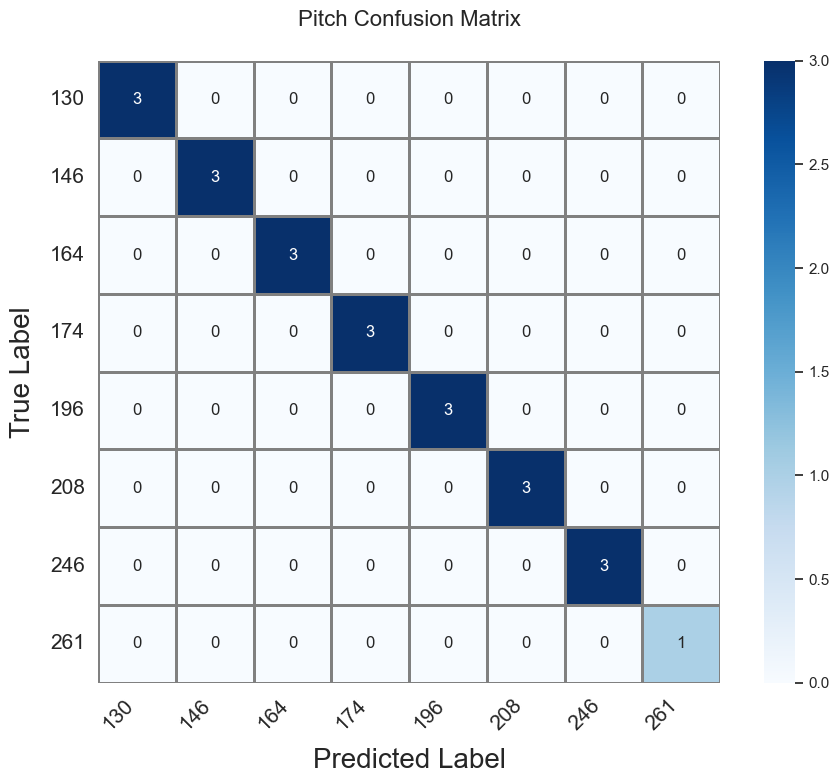

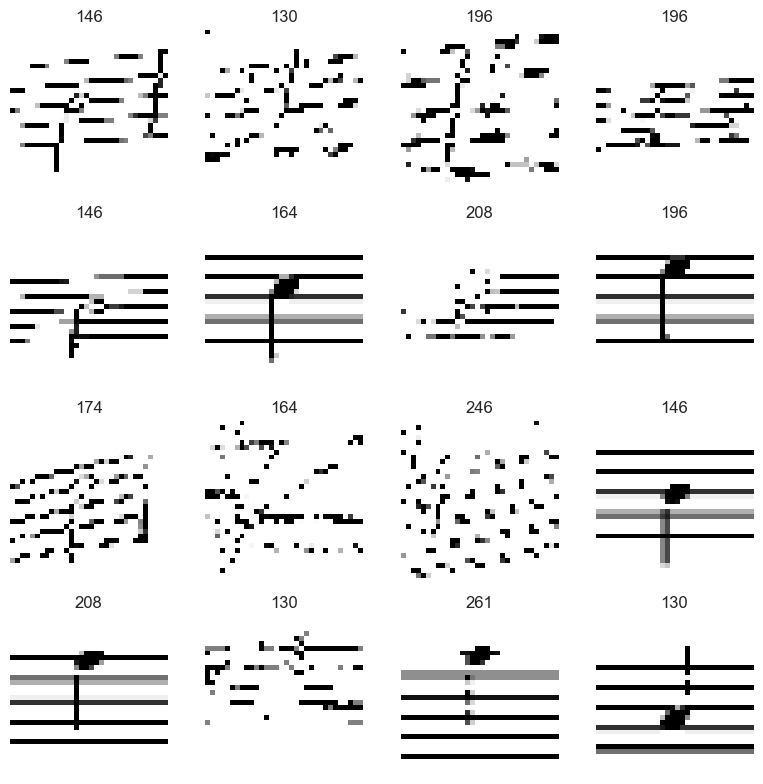

In [6]:
from sklearn.metrics import confusion_matrix
import torch

# 1️⃣ Put your model in evaluation mode
model.eval()

all_true = []
all_pred = []

# 2️⃣ Run through your dataset (e.g., validation or test DataLoader)
with torch.no_grad():
    for images, pitch_labels, dur_labels in dataloader:  # replace with your test dataloader
        pitch_out, dur_out = model(images)

        # Choose predicted class (argmax over output logits)
        pred_pitch = torch.argmax(pitch_out, dim=1)
        pred_dur = torch.argmax(dur_out, dim=1)

        # Append ground truth and predictions
        all_true.extend(pitch_labels.numpy())
        all_pred.extend(pred_pitch.numpy())

# 3️⃣ Compute confusion matrix
cm = confusion_matrix(all_true, all_pred)

# 4️⃣ Plot it
classes = train_dataset.unique_pitches  # or your pitch labels in the correct order
plt_fig = plot_confusion_matrix_seaborn(cm, classes, title="Pitch Confusion Matrix")



# Suppose you take a batch from your dataloader
images, pitch_labels, dur_labels = next(iter(dataloader))
pitch_names = [train_dataset.unique_pitches[i] for i in pitch_labels]

plot_image_matrix(images, pitch_names, n_rows=4, n_cols=4)